### AutoEncoder
- 입력값과 출력값이 같도록하는 신경망
- 은닉계층의 뉴련이 입력보다 적어 압축하는 효과, 노이즈 제거에 사용
- 비지도 학습에 일종임

https://sunghan-kim.github.io/ml/3min-dl-ch08/#81-%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94-%EA%B0%9C%EB%85%90
https://excelsior-cjh.tistory.com/187

https://teddylee777.github.io/tensorflow/autoencoder

https://github.com/teddylee777/data-science-for-fun/blob/master/02-tensorflow/05-auto-encoder/01-basic-auto-encoder-MNIST.ipynb

In [1]:
from tensorflow.keras.layers import Input,Conv2D, Conv2DTranspose, Dense, Flatten, Dropout, BatchNormalization, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()
x_train.shape, y_train.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,))

In [3]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train / 127.5 - 1       # Normailization :-1 ~ 1 사이의 값
x_train.min(), x_train.max()

(-1.0, 1.0)

In [4]:
# Encoder 모델 구현

encoder_input = Input(shape=(28, 28, 1))

# 28 X 28
x = Conv2D(32, 3, padding='same')(encoder_input) 
x = BatchNormalization()(x)
x = LeakyReLU()(x) 

# 28 X 28 -> 14 X 14
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x) 
x = LeakyReLU()(x) 

# 14 X 14 -> 7 X 7
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 17 X 7
x = Conv2D(64, 3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Flatten()(x)

# 2D 좌표로 표기하기 위하여 2를 출력값으로 지정합니다.
encoder_output = Dense(2)(x)

encoder = Model(encoder_input, encoder_output)
encoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)       

### LeakyReLU
https://forensics.tistory.com/23
- LeakyReLU 함수는 LReLU라고도 하며 ReLU 함수를 개량시킨 것으로 식 (8.6)과 같이 정의되며 α는 0.01과 같은 작은 상수값이다. <br>
- f(x)=max(αx,x) <br>
- LReLU의 그래프는 아래와 같으며, ReLU 함수와의 차이점은 α에 의해 x<0일 때도 작은 경사(\alpha)를 갖는다. LReLU 함수를 미분하면 다음과 같다. <br>
- f′(x)= 1 (x > 0)
- f′(x)= α (x <= 0)
        

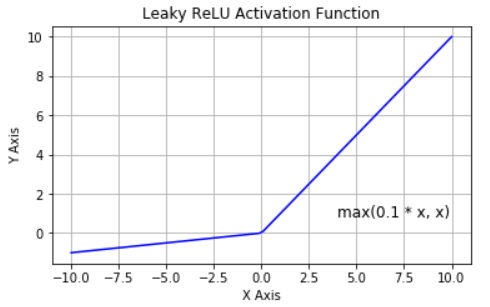

In [18]:
def lrelu(x, alpha=0.01):
    if x >= 0:
        return x
    else:
        return alpha * x

In [5]:
# Decoder 모델 구현
# Input으로는 2D 좌표가 들어갑니다.
decoder_input = Input(shape=(2, ))

# 2D 좌표를 7*7*64 개의 neuron 출력 값을 가지도록 변경합니다.
x = Dense(7*7*64)(decoder_input)
x = Reshape( (7, 7, 64))(x)

# 7 X 7 -> 7 X 7
x = Conv2DTranspose(64, 3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 7 X 7 -> 14 X 14
x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 14 X 14 -> 28 X 28
x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 28 X 28 -> 28 X 28
x = Conv2DTranspose(32, 3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 최종 output
decoder_output = Conv2DTranspose(1, 3, strides=1, padding='same', activation='tanh')(x)

decoder = Model(decoder_input, decoder_output)

decoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)       

In [6]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 32

encoder_in = Input(shape=(28, 28, 1))
x = encoder(encoder_in)
decoder_out = decoder(x)

auto_encoder = Model(encoder_in, decoder_out)

auto_encoder.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), 
                     loss=tf.keras.losses.MeanSquaredError())

checkpoint_path = '01-basic-auto-encoder-MNIST.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             monitor='loss', 
                             verbose=1)

In [7]:
# GPU 환경에서 약 25분 소요
auto_encoder.fit(x_train, x_train, 
                 batch_size=BATCH_SIZE, 
                 epochs=100, 
                 callbacks=[checkpoint], 
                )

Epoch 1/100
1872/1875 [============================>.] - ETA: 0s - loss: 0.2074
Epoch 00001: loss improved from inf to 0.20730, saving model to 01-basic-auto-encoder-MNIST.ckpt
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2073
Epoch 2/100
1873/1875 [============================>.] - ETA: 0s - loss: 0.1856
Epoch 00002: loss improved from 0.20730 to 0.18561, saving model to 01-basic-auto-encoder-MNIST.ckpt
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1856
Epoch 3/100
1875/1875 [==============================] - ETA: 0s - loss: 0.1783
Epoch 00003: loss improved from 0.18561 to 0.17831, saving model to 01-basic-auto-encoder-MNIST.ckpt
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1783
Epoch 4/100
1872/1875 [============================>.] - ETA: 0s - loss: 0.1734
Epoch 00004: loss improved from 0.17831 to 0.17337, saving model to 01-basic-auto-encoder-MNIST.ckpt
1875/1875 [==============================] - 14s 7ms/step - l

In [8]:
auto_encoder.load_weights(checkpoint_path)

##  시각화

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
decoded_images = auto_encoder.predict(x_train)

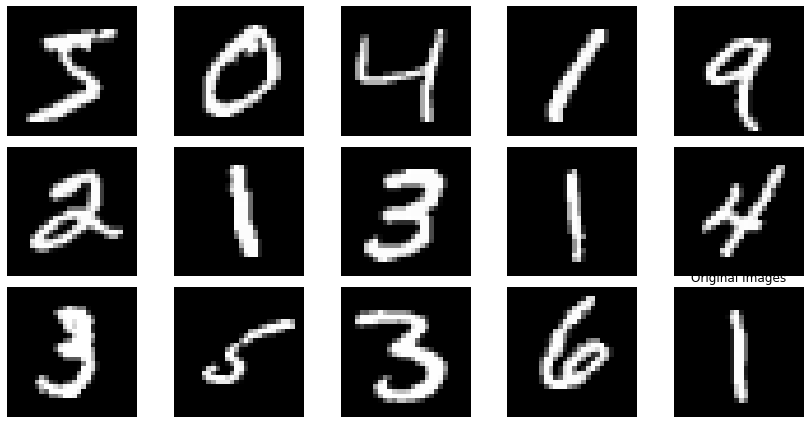

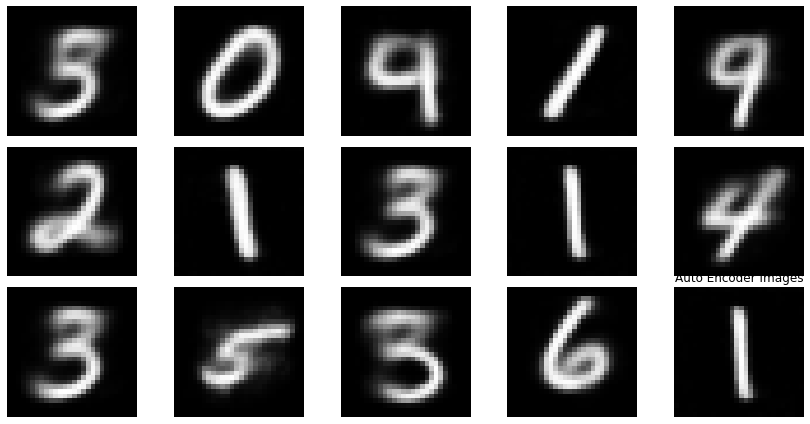

In [11]:
fig, axes = plt.subplots(3, 5)
fig.set_size_inches(12, 6)
for i in range(15):
    axes[i//5, i%5].imshow(x_train[i].reshape(28, 28), cmap='gray')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.title('Original Images')
plt.show()

fig, axes = plt.subplots(3, 5)
fig.set_size_inches(12, 6)
for i in range(15):
    axes[i//5, i%5].imshow(decoded_images[i].reshape(28, 28), cmap='gray')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.title('Auto Encoder Images')
plt.show()

In [12]:
# 첫번째 디코딩 된 이미지를 보면, 원본 이미지는 5이나, decoder 이미지는 3처럼 보인다. (3번째도 원래 4인데 9처럼 디코딩 되었다)
# 전체적으로 이미지 재구성에 대한 성능은 뛰어난 편이다.
# Decoder만 따로 떼내어, 임의의 X, Y 좌표를 넣어 주는 것으로 이미지를 새로 만들어 낼 수도 있다.